<a href="https://colab.research.google.com/github/nissrinayy/deeplearning/blob/main/Week7/BiRNN_IMDb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model BiRNN dengan Tensorflow : IMDb Dataset

In [1]:
# Install Keras Tuner (kalau belum)
!pip install -q keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.6 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os
import kerastuner as kt
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model


<ipython-input-2-11ce44f36f89>:9: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [3]:
# Set parameters
max_features = 10000  # number of words to consider as features
maxlen = 500  # cut texts after this number of words (among top max_features most common words)
batch_size = 64

In [4]:
# Load the IMDb dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
# Pad sequences to ensure consistent length
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

In [6]:
# Fungsi untuk menambahkan checkpoint
def create_checkpoint_callback():
    checkpoint_dir = '/content/checkpoints'  # Direktori untuk menyimpan model
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    checkpoint_path = os.path.join(checkpoint_dir, "model_best.h5")  # File untuk menyimpan model terbaik

    # Membuat callback untuk menyimpan model terbaik berdasarkan validasi akurasi
    checkpoint_callback = ModelCheckpoint(
        checkpoint_path,
        monitor='val_accuracy',  # Memantau akurasi validasi
        save_best_only=True,  # Hanya menyimpan model dengan akurasi validasi terbaik
        mode='max',  # Memilih nilai maksimum untuk validasi akurasi
        verbose=1  # Menampilkan informasi jika model disimpan
    )
    return checkpoint_callback

In [7]:
# Define the model-building function for hyperparameter tuning
def model_builder(hp):
    model = models.Sequential([
        layers.Embedding(max_features, 128, input_length=maxlen),
        layers.Bidirectional(layers.LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32),
                                         dropout=0.2, recurrent_dropout=0.2)),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  metrics=['accuracy'])

    return model

In [9]:
# Hyperparameter tuning using KerasTuner
checkpoint_callback = create_checkpoint_callback()

tuner = kt.Hyperband(model_builder, objective='val_accuracy', max_epochs=2, factor=3, directory='my_dir', project_name='imdb_birnn')
tuner.search(x_train, y_train, epochs=2, validation_data=(x_test, y_test), callbacks=[checkpoint_callback])


Trial 2 Complete [01h 27m 52s]
val_accuracy: 0.8810399770736694

Best val_accuracy So Far: 0.8810399770736694
Total elapsed time: 02h 56m 43s


In [10]:
# Get the best model from the hyperparameter tuning
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 500, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,378,945 (5.26 MB)

 Trainable params: 1,378,945 (5.26 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Train the best model with the tuned hyperparameters
history = best_model.fit(x_train, y_train, epochs=2, batch_size=batch_size, validation_data=(x_test, y_test), callbacks=[checkpoint_callback])


Epoch 1/2
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9485 - loss: 0.1407
Epoch 1: val_accuracy improved from -inf to 0.87912, saving model to /content/checkpoints/model_best.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 1305s 3s/step - accuracy: 0.9485 - loss: 0.1407 - val_accuracy: 0.8791 - val_loss: 0.3201
Epoch 2/2
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9685 - loss: 0.0922
Epoch 2: val_accuracy did not improve from 0.87912
391/391 ━━━━━━━━━━━━━━━━━━━━ 1350s 3s/step - accuracy: 0.9684 - loss: 0.0923 - val_accuracy: 0.8695 - val_loss: 0.3957


In [13]:
# Predict on the test data
y_pred = best_model.predict(x_test)
y_pred = (y_pred > 0.5).astype("int32")

782/782 ━━━━━━━━━━━━━━━━━━━━ 397s 507ms/step


In [14]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

In [15]:
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')

Accuracy: 0.8695
Precision: 0.8928
Recall: 0.8398
F1 Score: 0.8655
ROC AUC: 0.8695


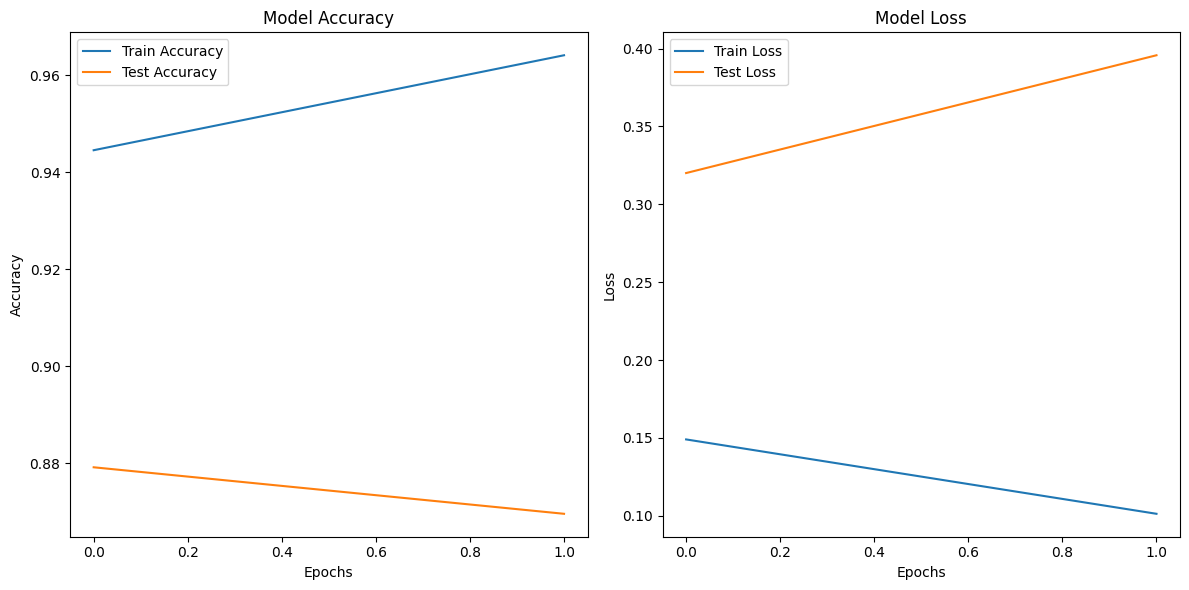

In [16]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
